In [1]:
from os.path import join
import os
from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import pandas as pd
from matplotlib.path import Path
from tqdm import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
VISION_CONE_ANGLE = 90

In [3]:
DATA_DIR = '../data/01_processed'
RESULTS_DIR = '../results'

In [4]:
def add_rb_coords(tracking):
    """Add ball carrier coordinates to tracking data"""
    rb_coords = (
        tracking[tracking['is_ball_carrier'] == 1]
        .set_index(['game_play_id', 'frame_id'])[['x', 'y']]
        .rename(columns={'x': 'ball_carrier_x', 'y': 'ball_carrier_y'})
    )
    tracking = tracking.merge(
        rb_coords,
        left_on=['game_play_id', 'frame_id'],
        right_index=True,
        how='left'
    )
    tracking['euclidean_dist_to_ball_carrier'] = (
        ((tracking['x'] - tracking['ball_carrier_x']) ** 2 +
         (tracking['y'] - tracking['ball_carrier_y']) ** 2) ** 0.5
    ).round(2)
    tracking.drop(columns=['ball_carrier_x', 'ball_carrier_y'], inplace=True)

    return tracking

tracking = (
    pd.read_parquet(join(DATA_DIR, 'tracking.parquet'))
    .query('club != "football"')
)

cols = ['x', 'y', 's', 'dir', 'offense', 'is_ball_carrier', 'position_by_loc']
tracking = tracking[['game_play_id', 'frame_id', 'nfl_id'] + cols].copy()

# Add euclidean_dist_to_ball_carrier column
tracking = add_rb_coords(tracking)

In [5]:
tracking.head()

,game_play_id,frame_id,nfl_id,x,y,s,dir,offense,is_ball_carrier,position_by_loc,euclidean_dist_to_ball_carrier
0,2022091200_64,124,35459.0,25.65,52.30,4.08,42.25,0,0,SS,20.75
1,2022091200_64,125,35459.0,25.96,52.58,4.27,40.16,0,0,SS,21.00
2,2022091200_64,126,35459.0,26.31,52.85,4.48,37.89,0,0,SS,21.24
3,2022091200_64,127,35459.0,26.69,53.10,4.66,32.21,0,0,SS,21.44
4,2022091200_64,128,35459.0,27.11,53.33,4.82,27.73,0,0,SS,21.60


In [6]:
game_play_ids = list(tracking['game_play_id'].unique())

grouped = {
    gpid: g.copy() for gpid, g in 
    tracking[tracking['game_play_id'].isin(game_play_ids)].groupby('game_play_id')
}

gpid = game_play_ids[1]
df_all = grouped[gpid]

In [7]:
# Identify O-line
oline_positions = ['LG', 'LT', 'C', 'RG', 'RT']
oline = df_all[df_all['position_by_loc'].isin(oline_positions)].copy()

oline_ids = list(oline['nfl_id'].unique())
positions_map = dict(
    zip(oline_ids, oline.groupby('nfl_id')['position_by_loc'].first())
)

if oline.position_by_loc.nunique() < 5:
    raise ValueError(f"Expected 5 unique O-line positions, found {oline.position_by_loc.nunique()}")

# Everyone else (RB, WR, defense, etc.)
non_oline_df = df_all[~df_all['nfl_id'].isin(oline_ids)]

In [8]:
import sys
import numpy as np
import pandas as pd
from helpers.influence import influence

rb_coords = None
fc = []

def get_rb_field_control(
    tracking,
    every_n_frames: int = 1,
    vision_cone_angle: int = 45,
) -> float:
    """Calculate RB field control for a given play.
    
    Args:
        tracking: DataFrame with tracking data for the play.
    Returns:
        Average field control value in the RB's vision cone across all frames.
    """

    fc_values = []
    frame_ids = tracking['frame_id'].unique()

    # If every_n_frames > 1, filter frames to reduce computation
    if every_n_frames > 1:
        frame_ids = sorted(tracking['frame_id'].unique())
        frame_ids = {fid for i, fid in enumerate(frame_ids) if i % every_n_frames == 0}
        tracking = tracking[tracking['frame_id'].isin(frame_ids)]

    for frame_id in frame_ids:

        # Ball carrier coordinates, speed, and direction
        rb_data = tracking.query(
            'is_ball_carrier == 1 and frame_id == @frame_id'
        )[['x', 'y', 'dir', 's']]
        if rb_data.empty:
            game_play_id = tracking['game_play_id'].unique()[0]
            print(f"No ball carrier data found for game_play_id {game_play_id} "
                  f"at frame {frame_id}.")
            return 0.0
        rb_x = rb_data['x'].values[0]
        rb_y = rb_data['y'].values[0]
        rb_dir = rb_data['dir'].values[0]
        global rb_coords
        rb_coords = _get_vision_cone(
            rb_pos = np.array([rb_x, rb_y]),
            rb_dir_rad = np.radians(rb_dir),
            cone_angle_deg=vision_cone_angle,
            cone_length=3,
            spacing=0.5
        )
        fc_values.append(_compute_field_control(
            tracking.query('frame_id == @frame_id and is_ball_carrier == 0'),
            rb_coords
        ))

    return np.mean(fc_values) if fc_values else 0.0

def _compute_field_control(
    frame_df: pd.DataFrame,
    rb_coords: np.ndarray,
) -> float:
    smoothing_param = sys.float_info.epsilon
    field_control = np.zeros(rb_coords.shape[:1])

    cols = ['x', 'y', 's', 'dir', 'offense', 'euclidean_dist_to_ball_carrier']
    for i, coord in enumerate(rb_coords):
        for row in frame_df[cols].itertuples(index=False):                    
            field_control[i] += influence(
                p=coord,
                p_i=np.array([row.x, row.y]),
                s=row.s + smoothing_param,
                theta=row.dir * np.pi / 180,
                rb_dist=row.euclidean_dist_to_ball_carrier,
                is_offense=row.offense
            )
    global fc
    fc = 1 / (1 + np.exp(-field_control))
    return np.mean(1 / (1 + np.exp(-field_control)))  # sigmoid normalization

def _get_vision_cone(
    rb_pos,
    rb_dir_rad,
    cone_angle_deg=45,
    cone_length=3,
    spacing=0.5
):
    """Generate evenly spaced points inside RB vision cone."""
    cone_half_angle = np.radians(cone_angle_deg / 2)

    # Create a grid that covers the cone bounding box
    max_radius = cone_length
    grid_x, grid_y = np.meshgrid(
        np.arange(-max_radius, max_radius + spacing, spacing),
        np.arange(-max_radius, max_radius + spacing, spacing)
    )
    points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

    # Keep only points in front of RB within cone length and angle
    dist = np.linalg.norm(points, axis=1)
    angles = np.arctan2(points[:, 1], points[:, 0])  # relative to facing +x
    mask = (
        (dist <= cone_length) &
        (np.abs(angles) <= cone_half_angle)
    )
    cone_points = points[mask]

    # Rotate and translate to RB position
    rot_matrix = np.array([
        [np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
        [np.sin(rb_dir_rad), np.cos(rb_dir_rad)]
    ])
    return (rot_matrix @ cone_points.T).T + rb_pos

def _get_rb_semicircle(
    rb_pos,
    rb_dir_rad,
    radius=1,
    cone_angle_deg=45,
    spacing=0.5
):
    """Generate evenly spaced points in semicircle behind RB."""
    excluded_half_angle = np.radians((cone_angle_deg) / 2)

    # Create a grid that covers full circle bounding box
    grid_x, grid_y = np.meshgrid(
        np.arange(-radius, radius + spacing, spacing),
        np.arange(-radius, radius + spacing, spacing)
    )
    points = np.column_stack([grid_x.ravel(), grid_y.ravel()])

    dist = np.linalg.norm(points, axis=1)
    angles = np.arctan2(points[:, 1], points[:, 0])  # relative to +x direction

    # Keep points within circle but outside cone wedge
    mask = (
        (dist <= radius) &
        ((angles > excluded_half_angle) | (angles < -excluded_half_angle))
    )
    semi_points = points[mask]

    # Rotate and translate to RB position
    rot_matrix = np.array([
        [np.cos(rb_dir_rad), -np.sin(rb_dir_rad)],
        [np.sin(rb_dir_rad), np.cos(rb_dir_rad)]
    ])
    return (rot_matrix @ semi_points.T).T + rb_pos

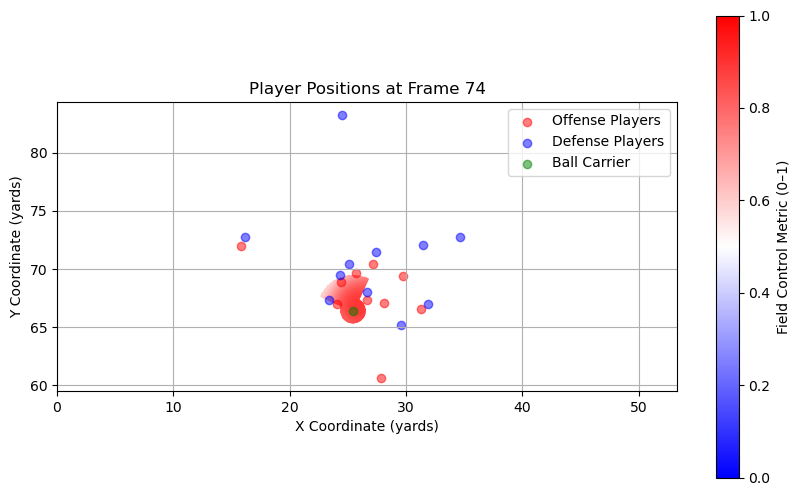

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

non_ball_carrier = pd.concat([
    oline,
    non_oline_df.query('is_ball_carrier == 0')
])

first_frame = non_oline_df.frame_id.unique()[10]

rb_data = non_oline_df.query('frame_id == @first_frame & is_ball_carrier == 1')

vision_cone_coords = _get_vision_cone(
    rb_pos=np.array([rb_data['x'].values[0], rb_data['y'].values[0]]),
    rb_dir_rad=np.radians(rb_data['dir'].values[0]),
    cone_angle_deg=90,
    cone_length=3,
    spacing=0.1
)

semicircle_coords = _get_rb_semicircle(
    rb_pos=np.array([rb_data['x'].values[0], rb_data['y'].values[0]]),
    rb_dir_rad=np.radians(rb_data['dir'].values[0]),
    radius=1,
    cone_angle_deg=90,
    spacing=0.05
)

rb_coords = np.vstack((vision_cone_coords, semicircle_coords))

_compute_field_control(
    df_all.query('frame_id == @first_frame'), rb_coords
)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Keep correct field proportions
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(0, 53.3)

# Offense players
ax.scatter(
    non_ball_carrier.query('offense == 1 and frame_id == @first_frame')['x'],
    non_ball_carrier.query('offense == 1  and frame_id == @first_frame')['y'],
    c='red', alpha=0.5, label='Offense Players', zorder=1
)

# Defense players
ax.scatter(
    non_oline_df.query('offense == 0 and frame_id == @first_frame')['x'],
    non_oline_df.query('offense == 0 and frame_id == @first_frame')['y'],
    c='blue', alpha=0.5, label='Defense Players', zorder=1
)

# O-line players
# ax.scatter(
#     oline.query('frame_id == @first_frame')['x'],
#     oline.query('frame_id == @first_frame')['y'],
#     c='darkred', alpha=0.5, label='O-line Players', zorder=1
# )

# Ball carrier
ax.scatter(
    df_all.query('is_ball_carrier == 1 and frame_id == @first_frame')['x'],
    df_all.query('is_ball_carrier == 1 and frame_id == @first_frame')['y'],
    c='green', alpha=0.5, label='Ball Carrier', zorder=1, 
)

# RB Vision Cone FC
sc = ax.scatter(
    rb_coords[:, 0], rb_coords[:, 1],
    s=1, c=fc, cmap='bwr', vmin=0, vmax=1,
    zorder=0
)

# Colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Field Control Metric (0–1)")

# Labels and formatting
ax.set_xlabel('X Coordinate (yards)')
ax.set_ylabel('Y Coordinate (yards)')
ax.set_title(f'Player Positions at Frame {first_frame}')
ax.legend()
ax.grid()

plt.show()


In [10]:
import numpy as np
import pandas as pd

def olineman_engaged_with_defender(
    olineman_df: pd.DataFrame,
    non_oline_df: pd.DataFrame,
    distance_threshold: float = 1.5,
) -> np.ndarray:
    """
    Determine if the O-lineman is engaged with a defender (one row per frame).
    Engagement = at least one defender within `distance_threshold`.
    """

    # Filter defenders once
    defenders_df = non_oline_df[non_oline_df["offense"] == 0]

    # Merge lineman and defenders on frame_id (all pairs per frame)
    merged = olineman_df.merge(
        defenders_df, on="frame_id", suffixes=("_oline", "_def")
    )

    # Compute distance between lineman and each defender
    dx = merged["x_oline"].to_numpy() - merged["x_def"].to_numpy()
    dy = merged["y_oline"].to_numpy() - merged["y_def"].to_numpy()
    dists = np.sqrt(dx**2 + dy**2)

    # Flag if engaged with at least one defender in that frame
    merged["engaged"] = (dists <= distance_threshold).astype(int)

    # Collapse to 1 row per frame: engaged if any defender is close
    engaged_per_frame = (
        merged.groupby("frame_id")["engaged"].max().reindex(olineman_df["frame_id"], fill_value=0)
    )

    # Smooth to engagement of at least 5 consecutive frames
    def mask_short_streaks(series: pd.Series, min_streak: int = 5) -> pd.Series:
        runs = (series != series.shift()).cumsum()
        run_lengths = series.groupby(runs).transform("size")
        return series.where((series == 0) | (run_lengths >= min_streak), 0)
    
    engaged_series = mask_short_streaks(engaged_per_frame, min_streak=5)

    return engaged_series.to_numpy()


In [11]:
np.random.randint(0, 2, size=len(oline['frame_id'].unique()))

array([1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0])

In [12]:
engaged_per_frame = pd.Series(
    [1,1,1,1,1,
     1,1,0,0,0,
     0,0,0,1,1,
     1,1,0,0,0,
     0,1,1,1,1,
     1,1]
)

def mask_short_streaks(series: pd.Series, min_streak: int = 5) -> pd.Series:
    # Identify runs by cumulative sum of changes
    runs = (series != series.shift()).cumsum()

    # Count size of each run
    run_lengths = series.groupby(runs).transform("size")

    # Keep only runs of 1s with length >= min_streak
    return series.where((series == 0) | (run_lengths >= min_streak), 0)

result = mask_short_streaks(engaged_per_frame, min_streak=5)
print(result.tolist())

[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


In [13]:
highlighe_player_engaged = olineman_engaged_with_defender(oline.query('nfl_id == @highlight_player'), non_oline_df)

UndefinedVariableError: local variable 'highlight_player' is not defined

In [14]:
highlighe_player_engaged

NameError: name 'highlighe_player_engaged' is not defined

In [24]:
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

gpid, highlight_player = '2022100906_2058',	52477.0		# '2022100205_3078',	52477.0
df_all = grouped[gpid]
oline_positions = ['LG', 'LT', 'C', 'RG', 'RT']
oline = df_all[df_all['position_by_loc'].isin(oline_positions)].copy()

oline_ids = list(oline['nfl_id'].unique())
positions_map = dict(
    zip(oline_ids, oline.groupby('nfl_id')['position_by_loc'].first())
)

if oline.position_by_loc.nunique() < 5:
    raise ValueError(f"Expected 5 unique O-line positions, found {oline.position_by_loc.nunique()}")

# Everyone else (RB, WR, defense, etc.)
non_oline_df = df_all[~df_all['nfl_id'].isin(oline_ids)]

non_ball_carrier = pd.concat([
    oline,
    non_oline_df.query('is_ball_carrier == 0')
])

# First, let's get all unique frame IDs
frame_ids = non_oline_df.frame_id.unique()

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

highlighe_player_engaged = olineman_engaged_with_defender(oline.query('nfl_id == @highlight_player'), non_oline_df)

def update(frame_id):
    ax.clear()
    
    # Get RB data for this frame
    rb_data = non_oline_df.query('frame_id == @frame_id & is_ball_carrier == 1')
    
    # Calculate RB vision cone
    vision_cone_coords = _get_vision_cone(
    rb_pos=np.array([rb_data['x'].values[0], rb_data['y'].values[0]]),
    rb_dir_rad=np.radians(rb_data['dir'].values[0]),
    cone_angle_deg=90,
    cone_length=3,
    spacing=0.1
)

    semicircle_coords = _get_rb_semicircle(
        rb_pos=np.array([rb_data['x'].values[0], rb_data['y'].values[0]]),
        rb_dir_rad=np.radians(rb_data['dir'].values[0]),
        radius=1,
        cone_angle_deg=90,
        spacing=0.05
    )

    rb_coords = np.vstack((vision_cone_coords, semicircle_coords))
    
    # Compute field control - ensure it returns an array
    _compute_field_control(
        df_all.query('frame_id == @frame_id and is_ball_carrier == 0'),
        rb_coords
    )
    
    # Set up the plot with correct proportions
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0, 53.3)
    ymin, ymax = df_all['y'].min() - 2, df_all['y'].max() + 2
    ax.set_ylim(ymin, ymax) 
    
    # Offense players
    ax.scatter(
        non_oline_df.query('offense == 1 and frame_id == @frame_id and nfl_id != @highlight_player')['x'],
        non_oline_df.query('offense == 1 and frame_id == @frame_id and nfl_id != @highlight_player')['y'],
        c='red', alpha=0.5, label='Offense Players', zorder=1
    )

    # Highlight specific player
    highlight_player_data = non_ball_carrier.query('nfl_id == @highlight_player and frame_id == @frame_id')
    if not highlight_player_data.empty:
        frame_id_index = np.where(frame_ids == frame_id)[0][0]

        if highlighe_player_engaged[frame_id_index]:
            ax.scatter(
                highlight_player_data['x'],
                highlight_player_data['y'],
                c='green', alpha=0.8, label='Highlighted Player (Engaged)',
                s=50, zorder=2, ec='yellow', lw=2
            )
        else:   
            ax.scatter(
                highlight_player_data['x'],
                highlight_player_data['y'],
                c='green', alpha=0.8, label='Highlighted Player',
                s=50, zorder=2
            )
    
    # Defense players
    ax.scatter(
        non_oline_df.query('offense == 0 and frame_id == @frame_id')['x'],
        non_oline_df.query('offense == 0 and frame_id == @frame_id')['y'],
        c='blue', alpha=0.5, label='Defense Players', zorder=1
    )
    
    # O-line players
    ax.scatter(
        oline.query('frame_id == @frame_id and nfl_id != @highlight_player')['x'],
        oline.query('frame_id == @frame_id and nfl_id != @highlight_player')['y'],
        c='purple', alpha=0.5, label='O-line Players', zorder=1
    )
    
    # Ball carrier
    ax.scatter(
        df_all.query('is_ball_carrier == 1 and frame_id == @frame_id')['x'],
        df_all.query('is_ball_carrier == 1 and frame_id == @frame_id')['y'],
        c='red', alpha=0.5, label='Ball Carrier', s=70, zorder=1, ec='black', lw=2
    )
    
    # RB Vision Cone FC (keeps color mapping but no colorbar)
    sc = ax.scatter(
        rb_coords[:, 0], rb_coords[:, 1],
        s=1, c=fc, cmap='bwr', vmin=0, vmax=1,  # Still using color mapping
        zorder=0
    )
    
    # Labels and formatting
    ax.set_xlabel('X Coordinate (yards)')
    ax.set_ylabel('Y Coordinate (yards)')
    ax.set_title(f'Player Positions at Frame {frame_id}')
    ax.legend(loc='upper right')
    ax.grid()
    
    return sc,

# Create the animation
ani = animation.FuncAnimation(
    fig, 
    update, 
    frames=frame_ids,
    interval=200,  # Time between frames in ms
    blit=False,
    repeat=False
)

# Display in notebook
plt.close()  # Prevents duplicate display
HTML(ani.to_html5_video())

In [25]:
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

gpid, highlight_player = '2022102700_3806',	43295.0	
df_all = grouped[gpid]
oline_positions = ['LG', 'LT', 'C', 'RG', 'RT']
oline = df_all[df_all['position_by_loc'].isin(oline_positions)].copy()

oline_ids = list(oline['nfl_id'].unique())
positions_map = dict(
    zip(oline_ids, oline.groupby('nfl_id')['position_by_loc'].first())
)

if oline.position_by_loc.nunique() < 5:
    raise ValueError(f"Expected 5 unique O-line positions, found {oline.position_by_loc.nunique()}")

# Everyone else (RB, WR, defense, etc.)
non_oline_df = df_all[~df_all['nfl_id'].isin(oline_ids)]

non_ball_carrier = pd.concat([
    oline,
    non_oline_df.query('is_ball_carrier == 0')
])

# First, let's get all unique frame IDs
frame_ids = non_oline_df.frame_id.unique()

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

highlighe_player_engaged = olineman_engaged_with_defender(oline.query('nfl_id == @highlight_player'), non_oline_df)

def update(frame_id):
    ax.clear()
    
    # Get RB data for this frame
    rb_data = non_oline_df.query('frame_id == @frame_id & is_ball_carrier == 1')
    
    # Calculate RB vision cone
    vision_cone_coords = _get_vision_cone(
    rb_pos=np.array([rb_data['x'].values[0], rb_data['y'].values[0]]),
    rb_dir_rad=np.radians(rb_data['dir'].values[0]),
    cone_angle_deg=90,
    cone_length=3,
    spacing=0.1
)

    semicircle_coords = _get_rb_semicircle(
        rb_pos=np.array([rb_data['x'].values[0], rb_data['y'].values[0]]),
        rb_dir_rad=np.radians(rb_data['dir'].values[0]),
        radius=1,
        cone_angle_deg=90,
        spacing=0.05
    )

    rb_coords = np.vstack((vision_cone_coords, semicircle_coords))
    
    # Compute field control - ensure it returns an array
    _compute_field_control(
        df_all.query('frame_id == @frame_id and is_ball_carrier == 0'),
        rb_coords
    )
    
    # Set up the plot with correct proportions
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0, 53.3)
    ymin, ymax = df_all['y'].min() - 2, df_all['y'].max() + 2
    ax.set_ylim(ymin, ymax) 
    
    # Offense players
    ax.scatter(
        non_oline_df.query('offense == 1 and frame_id == @frame_id and nfl_id != @highlight_player')['x'],
        non_oline_df.query('offense == 1 and frame_id == @frame_id and nfl_id != @highlight_player')['y'],
        c='red', alpha=0.5, label='Offense Players', zorder=1
    )

    # Highlight specific player
    highlight_player_data = non_ball_carrier.query('nfl_id == @highlight_player and frame_id == @frame_id')
    if not highlight_player_data.empty:
        frame_id_index = np.where(frame_ids == frame_id)[0][0]

        if highlighe_player_engaged[frame_id_index]:
            ax.scatter(
                highlight_player_data['x'],
                highlight_player_data['y'],
                c='green', alpha=0.8, label='Highlighted Player (Engaged)',
                s=50, zorder=2, ec='yellow', lw=2
            )
        else:   
            ax.scatter(
                highlight_player_data['x'],
                highlight_player_data['y'],
                c='green', alpha=0.8, label='Highlighted Player',
                s=50, zorder=2
            )
    
    # Defense players
    ax.scatter(
        non_oline_df.query('offense == 0 and frame_id == @frame_id')['x'],
        non_oline_df.query('offense == 0 and frame_id == @frame_id')['y'],
        c='blue', alpha=0.5, label='Defense Players', zorder=1
    )
    
    # O-line players
    ax.scatter(
        oline.query('frame_id == @frame_id and nfl_id != @highlight_player')['x'],
        oline.query('frame_id == @frame_id and nfl_id != @highlight_player')['y'],
        c='purple', alpha=0.5, label='O-line Players', zorder=1
    )
    
    # Ball carrier
    ax.scatter(
        df_all.query('is_ball_carrier == 1 and frame_id == @frame_id')['x'],
        df_all.query('is_ball_carrier == 1 and frame_id == @frame_id')['y'],
        c='red', alpha=0.5, label='Ball Carrier', s=70, zorder=1, ec='black', lw=2
    )
    
    # RB Vision Cone FC (keeps color mapping but no colorbar)
    sc = ax.scatter(
        rb_coords[:, 0], rb_coords[:, 1],
        s=1, c=fc, cmap='bwr', vmin=0, vmax=1,  # Still using color mapping
        zorder=0
    )
    
    # Labels and formatting
    ax.set_xlabel('X Coordinate (yards)')
    ax.set_ylabel('Y Coordinate (yards)')
    ax.set_title(f'Player Positions at Frame {frame_id}')
    ax.legend(loc='upper right')
    ax.grid()
    
    return sc,

# Create the animation
ani = animation.FuncAnimation(
    fig, 
    update, 
    frames=frame_ids,
    interval=200,  # Time between frames in ms
    blit=False,
    repeat=False
)

# Display in notebook
plt.close()  # Prevents duplicate display
HTML(ani.to_html5_video())

In [26]:
oline_atttributions = pd.read_csv(join('../results', 'oline_loo_attribution_v2_90.csv'))
oline_atttributions.head()

,game_play_id,player_id,position,fc_attribution,baseline_fc
0,2022090800_101,35472.0,LG,0.008760,[0.50568384 0.5034648 0.4598981 0.34278423 0...
1,2022090800_101,42392.0,C,0.013446,[0.50568384 0.5034648 0.4598981 0.34278423 0...
2,2022090800_101,44875.0,LT,0.030068,[0.50568384 0.5034648 0.4598981 0.34278423 0...
3,2022090800_101,48512.0,RG,0.025723,[0.50568384 0.5034648 0.4598981 0.34278423 0...
4,2022090800_101,53522.0,RT,0.027829,[0.50568384 0.5034648 0.4598981 0.34278423 0...


In [16]:
plays = pd.read_parquet(join(DATA_DIR, 'plays.parquet'))

In [19]:
oline_atttributions.merge(plays[['game_play_id','yards_gained']], on='game_play_id').sort_values(by='fc_attribution', ascending=False).drop('baseline_fc', axis=1).head(100)

,game_play_id,player_id,position,fc_attribution,yards_gained
10492,2022100906_2058,52477.0,LG,0.192346,4
1218,2022091107_1717,53443.0,RG,0.186145,22
12134,2022101601_1246,52418.0,LT,0.184737,2
15972,2022102700_3806,43295.0,LT,0.177660,5
2510,2022091801_3462,41264.0,LG,0.176934,-3
11263,2022100910_3131,53477.0,LG,0.173287,5
3617,2022091809_1360,52938.0,RT,0.168896,11
371,2022091101_3336,44870.0,C,0.168387,2
370,2022091101_3336,41264.0,LG,0.168262,2
5876,2022092508_1067,41475.0,LT,0.168143,7


In [ ]:
# bad block, center allows defenter to be able to get to behind rb -  should have semicircle added bakc? - 2022091810_2764	52491.0	
# good block example: 2022100205_3078	41310.0	